#### Importing libraries

In [1]:
import matplotlib.pyplot as plt  # Importing Matplotlib for creating visualizations and plots.
import random  # Importing the 'random' module for generating random numbers and making random selections.
import numpy as np  # Importing NumPy, a library for numerical operations, used here for handling and manipulating image data arrays.

---

### Reading data

In [28]:
import numpy as np

# Load the datasets
train_images = np.load('data/train_images.npy')
train_labels = np.load('data/train_labels.npy')
val_images = np.load('data/val_images.npy')
val_labels = np.load('data/val_labels.npy')
test_images = np.load('data/test_images.npy')
test_labels = np.load('data/test_labels.npy')

# Print basic information about each dataset
print(f"Training images: {train_images.shape}, Training labels: {train_labels.shape}")
print(f"Validation images: {val_images.shape}, Validation labels: {val_labels.shape}")
print(f"Testing images: {test_images.shape}, Testing labels: {test_labels.shape}")


Training images: (9711, 512, 512, 3), Training labels: (9711,)
Validation images: (3237, 512, 512, 3), Validation labels: (3237,)
Testing images: (3237, 512, 512, 3), Testing labels: (3237,)


- The training dataset consists of 9,711 samples of 512x512 RGB images, while the validation and testing sets each contain 3,237 samples.

---

### Visualising the data

The dataset we will be working with contains five classes, described as follows:
- **Blurry**: Data captured while the satellite is in motion, resulting in blurred images.
- **Corrupt**: Images with defects from improper camera priming or stray light.
- **Missing Data**: Images with partial or complete data loss.
- **Noisy**: Images over-saturated with noise from radiation or other sources.
- **Priority**: Clear images suitable for scientific analysis on the ground.

Now, Let’s take a look at these datasets.

In [3]:
min_num_images_to_display = 5
num_images_to_process = 100

# Define the class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Get the unique labels in the training set
unique_labels = np.unique(train_labels)

In [4]:
# # Display the first 5 images for each class
# for label in unique_labels:
#     # Find the indices of images belonging to the current class
#     class_indices = np.where(train_labels == label)[0]
    
#     # Select the first 5 images of this class
#     num_images_to_display = min(min_num_images_to_display, len(class_indices))
#     selected_indices = class_indices[:num_images_to_display]
#     selected_images = train_images[selected_indices] / 255.0  # Normalize images for better visualization

#     # Plot the selected images
#     fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))
#     fig.suptitle(f'Class: {class_names[label]}', fontsize=16)
#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
#     for i, ax in enumerate(axes):
#         ax.imshow(selected_images[i])
#         ax.axis('off')
    
#     plt.show()
#     print()

## Helper Functions

In [5]:
import numpy as np

def detect_uniform_patches(image):
    """Detects solid color (corrupt) or black patches (missing data)."""
    hist, _ = np.histogram(image.ravel(), bins=256, range=(0, 1))
    # print(np.max(hist) / np.sum(hist))
    return np.max(hist) / np.sum(hist)  # Ratio of most common intensity

In [6]:
import numpy as np
from scipy.ndimage import convolve

def laplacian_variance(image):
    """Compute Laplacian variance to measure image sharpness using NumPy."""
    
    # Define the Laplacian kernel (3x3)
    laplacian_kernel = np.array([
        [0,  1,  0],
        [1, -4,  1],
        [0,  1,  0]
    ])

    # Apply the Laplacian filter using convolution
    laplacian_filtered = convolve(image, laplacian_kernel, mode='reflect')

    # Compute variance of the Laplacian response
    variance = laplacian_filtered.var()
    
    return variance


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Function to apply Gaussian filter and compute sharpness feature
def gaussian_blur_feature(image, sigma=1):
    """
    Apply a Gaussian filter and compute the variance of the residual image.
    
    - sigma: Controls the amount of blur.
    - Returns: Variance of the residual (original - blurred)
    """
    blurred = gaussian_filter(image, sigma=sigma)  # Apply Gaussian Blur
    residual = image - blurred  # Compute the Difference
    return np.var(residual)  # Compute variance of residual



In [8]:
# Function to apply Histogram Equalization using NumPy
def histogram_equalization(image):
    """Apply histogram equalization to a grayscale image."""
    image_flattened = image.flatten()  # Flatten image into 1D

    # Compute histogram
    hist, bins = np.histogram(image_flattened, bins=256, range=(0, 1), density=True)

    # Compute the Cumulative Distribution Function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()  # Normalize to range [0,1]

    # Use linear interpolation to find new pixel values
    equalized_image = np.interp(image_flattened, bins[:-1], cdf_normalized)

    return equalized_image.reshape(image.shape)  # Reshape back to original image size

In [9]:
# Function to convert RGB image to grayscale using NumPy
def rgb_to_grayscale(image):
    """Convert an RGB image to grayscale using NumPy."""
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Luminosity formula

In [10]:
from skimage.color import rgb2gray
def black_pixel_ratio(image, threshold=0.05):
    # gray = rgb_to_grayscale(image)  # Convert to grayscale (skimage)
    
    # # Normalize to range [0, 255] (assuming original range is [0, 1])
    # gray = (gray * 255).astype(np.uint8)

    # return black_pixel_ratio

    black_pixels = np.sum(image <= threshold)  # Count pixels that are ≤ threshold
    total_pixels = image.size  # Total number of pixels in the image

    return black_pixels / total_pixels  # Ratio of black pixels

In [11]:
from skimage.color import rgb2gray
def row_variance(image):
    # gray = rgb2gray(image)  # Convert to grayscale (skimage)

    # # Normalize to range [0, 255] (assuming original range is [0, 1])
    # gray = (gray * 255).astype(np.uint8)
    
    row_variance = np.var(np.mean(image, axis=1))  # Variance along rows

    return row_variance

In [12]:
from skimage.color import rgb2gray
def column_variance(image):
    # gray = rgb2gray(image)  # Convert to grayscale (skimage)

    # # Normalize to range [0, 255] (assuming original range is [0, 1])
    # gray = (gray * 255).astype(np.uint8)
    
    col_variance = np.var(np.mean(image, axis=0))  # Variance along columns

    return col_variance

In [13]:
# Function to normalize Laplacian Variance scores
def normalize_values(values):
    """Normalize a list of values to be between 0 and 1."""
    min_val = np.min(values)
    max_val = np.max(values)
    return (values - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(values)

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.transform import resize

# # Define class names
# class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]



# # Get unique labels
# unique_labels = np.unique(train_labels)

# RESIZED_SHAPE = (32, 32)

# # Display images for each class
# for label in unique_labels:
#     # Find the indices of images belonging to the current class
#     class_indices = np.where(train_labels == label)[0]
    
#     # Select the first 5 images of this class
#     num_images_to_display = min(5, len(class_indices))
#     selected_indices = class_indices[:num_images_to_display]
#     selected_images = train_images[selected_indices] / 255.0  # Normalize for better visualization

#     # Plot the selected images
#     fig, axes = plt.subplots(num_images_to_display, 7, figsize=(20, 4 * num_images_to_display)) 
#     fig.suptitle(f'Class: {class_names[label]}', fontsize=16)

    
#     for i, img in enumerate(selected_images):
#         # Extract R, G, B channels
#         red_channel = img.copy()
#         # red_channel[:, :, 1:] = 0  # Set Green and Blue to 0
#         red_channel[:, :, [1,2]] = 0  # Set Green and Blue to 0
        
#         green_channel = img.copy()
#         green_channel[:, :, [0, 2]] = 0  # Set Red and Blue to 0
        
#         blue_channel = img.copy()
#         # blue_channel[:, :, :2] = 0  # Set Red and Green to 0
#         blue_channel[:, :, [0,1]] = 0  # Set Red and Green to 0

#         # Convert to grayscale using NumPy function
#         grayscale = rgb_to_grayscale(img)

#         # Apply Histogram Equalization
#         equalized_image = histogram_equalization(grayscale)

#         # Resize the equalized image
#         resized_equalized = resize(equalized_image, RESIZED_SHAPE, anti_aliasing=True)
        
#         # Plot all variations
#         axes[i, 0].imshow(img)
#         axes[i, 0].set_title("Original")
        
#         axes[i, 1].imshow(red_channel)
#         axes[i, 1].set_title("Red Channel")
        
#         axes[i, 2].imshow(green_channel)
#         axes[i, 2].set_title("Green Channel")
        
#         axes[i, 3].imshow(blue_channel)
#         axes[i, 3].set_title("Blue Channel")
        
#         axes[i, 4].imshow(grayscale, cmap='gray')
#         axes[i, 4].set_title("Grayscale (NumPy)")

#         axes[i, 5].imshow(equalized_image, cmap='gray')
#         axes[i, 5].set_title("Equalized Grayscale")

#         axes[i, 6].imshow(resized_equalized, cmap='gray')
#         axes[i, 6].set_title("Resized Equalized Grayscale")
        
#         # Remove axis
#         for j in range(7):
#             axes[i, j].axis("off")

    
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
#     print()




In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

# # Define class names
# class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# # Function to convert RGB image to grayscale using NumPy
# def rgb_to_grayscale(image):
#     """Convert an RGB image to grayscale using NumPy."""
#     return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Luminosity formula




# # Get unique labels
# unique_labels = np.unique(train_labels)

# # Display images for each class
# for label in unique_labels:
#     # Find the indices of images belonging to the current class
#     class_indices = np.where(train_labels == label)[0]
    
#     # Select the first x images of this class
#     num_images_to_display = min(num_images_to_process, len(class_indices))
#     selected_indices = class_indices[:num_images_to_display]
#     selected_images = train_images[selected_indices] / 255.0  # Normalize for better visualization

#     grayscale_laplacian_variances = []
#     grayscale_uniform_patches = []
#     grayscale_gaussian_blurs = []
    
#     for i, img in enumerate(selected_images):
#         # Convert to grayscale using NumPy function
#         grayscale_image = rgb_to_grayscale(img)

#         equalised_image = histogram_equalization(grayscale_image)
        
#         grayscale_precise = grayscale_image.astype(np.float32)  # Ensure float type for precision
        
#         grayscale_blur_score = laplacian_variance(grayscale_precise)
#         grayscale_laplacian_variances.append(grayscale_blur_score)

#         grayscale_uniformity_score = detect_uniform_patches(grayscale_precise)
#         grayscale_uniform_patches.append(grayscale_uniformity_score)

#         grayscale_gaussian_blur = gaussian_blur_feature(grayscale_precise)
#         grayscale_gaussian_blurs.append(grayscale_gaussian_blur)

        
#     # Normalize the Laplacian variance scores to be between 0 and 1
#     normalized_grayscale_variances = normalize_values(np.array(grayscale_laplacian_variances))
#     normalised_grayscale_uniform_patches = normalize_values(np.array(grayscale_uniform_patches))
#     normalised_grayscale_gaussian_blurs = normalize_values(np.array(grayscale_gaussian_blurs))

    
#     fig, axes = plt.subplots(1, 3, figsize=(20, 4))

#     print(class_names[label])
#     # sns.kdeplot(normalized_variances, ax=axes[0], fill=True, color='gray', bw_adjust=0.5)
#     axes[0].hist(normalized_grayscale_variances, bins=10, alpha=0.7, color='gray', edgecolor='black')
#     axes[0].set_title(f"Grayscale - {class_names[label]}")
#     axes[0].set_xlabel("Laplacian Variance")
#     axes[0].set_ylabel("Frequency")
#     # axes[1].set_xlim(0, 1)

#     # sns.kdeplot(normalized_variances, ax=axes[0], fill=True, color='gray', bw_adjust=0.5)
#     axes[1].hist(normalised_grayscale_uniform_patches, bins=10, alpha=0.7, color='gray', edgecolor='black')
#     axes[1].set_title(f"Graysacle - {class_names[label]}")
#     axes[1].set_xlabel("Uniform Patches")
#     axes[1].set_ylabel("Frequency")
#     # axes[1].set_xlim(0, 1)

#     axes[2].hist(normalised_grayscale_gaussian_blurs, bins=10, alpha=0.7, color='gray', edgecolor='black')
#     axes[2].set_title(f"Graysacle - {class_names[label]}")
#     axes[2].set_xlabel("Gaussian Blur")
#     axes[2].set_ylabel("Frequency")
    
    
#     # axes[1].set_xlim(0, 1)
#     # Show the histogram
    
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

    
#     # print()
#     # print(f"Mean for {class_names[label]}")
#     # print("="*50)
#     # print(f"Grayscale Laplacian Variance: ", np.mean(normalized_grayscale_variances).round(3))
#     # print(f"Grayscale Uniform Patches: ", np.mean(normalised_grayscale_uniform_patches).round(3))

#     # print()
#     # print(f"Median for {class_names[label]}")
#     # print("="*50)
#     # print(f"Grayscale Laplacian Variance: ", np.median(normalized_grayscale_variances).round(3))
#     # print(f"Grayscale Uniform Patches: ", np.median(normalised_grayscale_uniform_patches).round(3))
#     # print()

#     # print()
#     # print(f"Mode for {class_names[label]}")
#     # print("="*50)
#     # print(f"Grayscale Laplacian Variance: ", stats.mode(normalized_grayscale_variances))
#     # print(f"Grayscale Uniform Patches: ", stats.mode(normalised_grayscale_uniform_patches))
#     # print()

#     print()
#     print(f"Laplacian Variance: for {class_names[label]}")
#     print("="*50)
#     print(f"Mean: ", np.mean(normalized_grayscale_variances).round(3))
#     print(f"Median: ", np.median(normalized_grayscale_variances).round(3))
#     # print(f"Mode", stats.mode(normalized_grayscale_variances))
#     print()
    
#     print()
#     print(f"Uniform Patches: for {class_names[label]}")
#     print("="*50)
#     print(f"Mean: ", np.mean(normalised_grayscale_uniform_patches).round(3))
#     print(f"Median: ", np.median(normalised_grayscale_uniform_patches).round(3))
#     print()

#     print()
#     print(f"Gaussian Blur: for {class_names[label]}")
#     print("="*50)
#     print(f"Mean: ", np.mean(normalised_grayscale_gaussian_blurs).round(3))
#     print(f"Median: ", np.median(normalised_grayscale_gaussian_blurs).round(3))
#     print()
    
#     # print(f"Mode: ", stats.mode(normalised_grayscale_uniform_patches))
#     print()


In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

# # Define class names
# class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# # Function to convert RGB image to grayscale using NumPy
# def rgb_to_grayscale(image):
#     """Convert an RGB image to grayscale using NumPy."""
#     return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Luminosity formula

# # Function to normalize Laplacian Variance scores
# def normalize_values(values):
#     """Normalize a list of values to be between 0 and 1."""
#     min_val = np.min(values)
#     max_val = np.max(values)
#     return (values - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(values)


# # Get unique labels
# unique_labels = np.unique(train_labels)

# # Display images for each class
# for label in unique_labels:
#     # Find the indices of images belonging to the current class
#     class_indices = np.where(train_labels == label)[0]
    
#     # Select the first x images of this class
#     num_images_to_display = min(num_images_to_process, len(class_indices))
#     selected_indices = class_indices[:num_images_to_display]
#     selected_images = train_images[selected_indices] / 255.0  # Normalize for better visualization

#     equalised_laplacian_variances = []
#     equalised_uniform_patches = []
#     equalised_gaussian_blurs = []
    
#     for i, img in enumerate(selected_images):
#         # Convert to grayscale using NumPy function
#         grayscale_image = rgb_to_grayscale(img)

#         equalised_image = histogram_equalization(grayscale_image)

#         equalised_blur_score = laplacian_variance(equalised_image)
#         equalised_laplacian_variances.append(equalised_blur_score)

#         equalised_uniformity_score = detect_uniform_patches(equalised_image)
#         equalised_uniform_patches.append(equalised_uniformity_score)

#         equalised_gaussian_blur = gaussian_blur_feature(equalised_image)
#         equalised_gaussian_blurs.append(equalised_gaussian_blur)

#     normalized_equalised_variances = normalize_values(np.array(equalised_laplacian_variances))
#     normalised_equalised_uniform_patches = normalize_values(np.array(equalised_uniform_patches))
#     normalised_equalised_gaussian_blurs = normalize_values(np.array(equalised_gaussian_blurs))
    
#     fig, axes = plt.subplots(1, 3, figsize=(20, 4))

#     print(class_names[label])
    
#     # sns.kdeplot(normalised_uniform_patches, ax=axes[1], fill=True, color='gray', bw_adjust=0.5)
#     axes[0].hist(normalized_equalised_variances, bins=10, alpha=0.7, color='gray', edgecolor='black')
#     axes[0].set_title(f"Equalised - {class_names[label]}")
#     axes[0].set_xlabel("Laplacian Variance")
#     axes[0].set_ylabel("Frequency")

#     # sns.kdeplot(normalised_uniform_patches, ax=axes[1], fill=True, color='gray', bw_adjust=0.5)
#     axes[1].hist(normalised_equalised_uniform_patches, bins=10, alpha=0.7, color='gray', edgecolor='black')
#     axes[1].set_title(f"Equalised - {class_names[label]}")
#     axes[1].set_xlabel("Uniform Patches")
#     axes[1].set_ylabel("Frequency")

#     # sns.kdeplot(normalised_uniform_patches, ax=axes[1], fill=True, color='gray', bw_adjust=0.5)
#     axes[2].hist(normalised_equalised_gaussian_blurs, bins=10, alpha=0.7, color='gray', edgecolor='black')
#     axes[2].set_title(f"Equalised - {class_names[label]}")
#     axes[2].set_xlabel("Gaussian Blurs")
#     axes[2].set_ylabel("Frequency")
#     # axes[1].set_xlim(0, 1)
#     # Show the histogram
    
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

    
#     # print()
#     # print(f"Mean for {class_names[label]}")
#     # print("="*50)
#     # print(f"Equalised Laplacian Variance: ", np.mean(normalized_equalised_variances).round(3))
#     # print(f"Equalised Uniform Patches: ", np.mean(normalised_equalised_uniform_patches).round(3))

#     # print()
#     # print(f"Median for {class_names[label]}")
#     # print("="*50)
#     # print(f"Equalised Laplacian Variance: ", np.median(normalized_equalised_variances).round(3))
#     # print(f"Equalised Uniform Patches: ", np.median(normalised_equalised_uniform_patches).round(3))
#     # print()

#     # print()
#     # print(f"Mode for {class_names[label]}")
#     # print("="*50)
#     # print(f"Grayscale Laplacian Variance: ", stats.mode(normalized_grayscale_variances))
#     # print(f"Grayscale Uniform Patches: ", stats.mode(normalised_grayscale_uniform_patches))



#     print("Equalised")
#     print()
#     print(f"Laplacian Variance: for {class_names[label]}")
#     print("="*50)
#     print(f"Mean: ", np.mean(normalized_equalised_variances).round(3))
#     print(f"Median: ", np.median(normalized_equalised_variances).round(3))
#     # print(f"Mode", stats.mode(normalized_equalised_variances))
#     print()
    
#     print()
#     print(f"Uniform Patches: for {class_names[label]}")
#     print("="*50)
#     print(f"Mean: ", np.mean(normalised_equalised_uniform_patches).round(3))
#     print(f"Median: ", np.median(normalised_equalised_uniform_patches).round(3))
#     print()

#     print()
#     print(f"Gaussian Blur: for {class_names[label]}")
#     print("="*50)
#     print(f"Mean: ", np.mean(normalised_equalised_gaussian_blurs).round(3))
#     print(f"Median: ", np.median(normalised_equalised_gaussian_blurs).round(3))
#     print()
#     # print(f"Mode: ", stats.mode(normalised_equalised_uniform_patches))
#     print()


Blurry
Equalised

Black Pixel Ratio for Blurry
Mean:  0.092
Median:  0.007


Row Variance for Blurry
Mean:  0.135
Median:  0.068


Column Variance for Blurry
Mean:  0.133
Median:  0.078



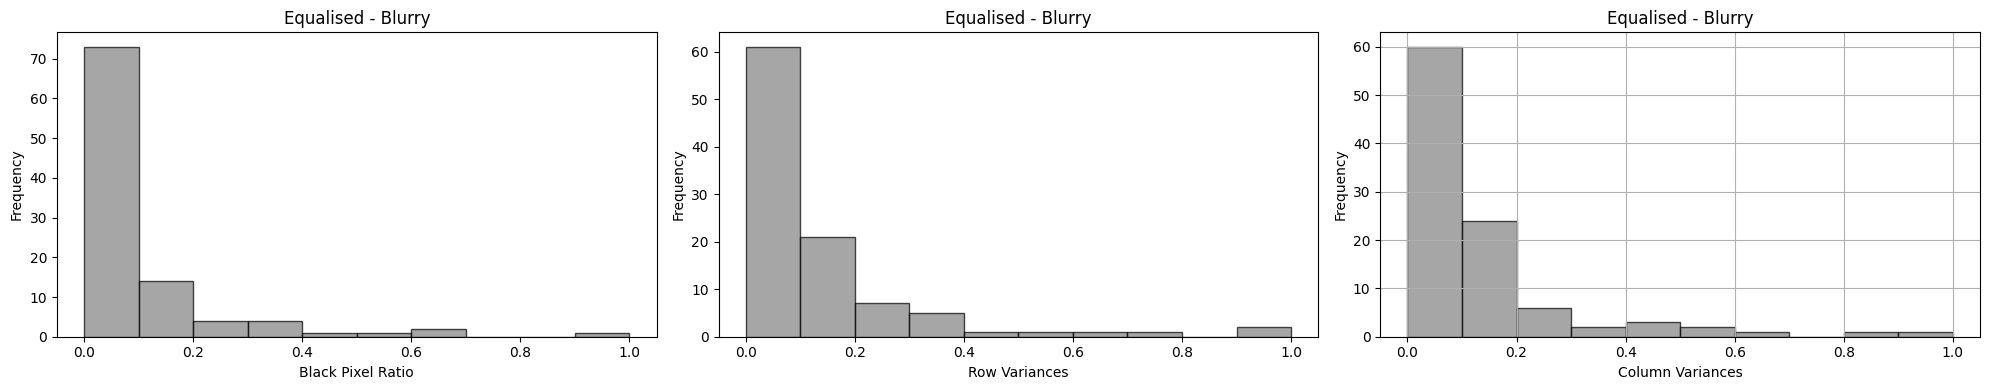

Corrupt
Equalised

Black Pixel Ratio for Corrupt
Mean:  0.164
Median:  0.0


Row Variance for Corrupt
Mean:  0.403
Median:  0.371


Column Variance for Corrupt
Mean:  0.286
Median:  0.33



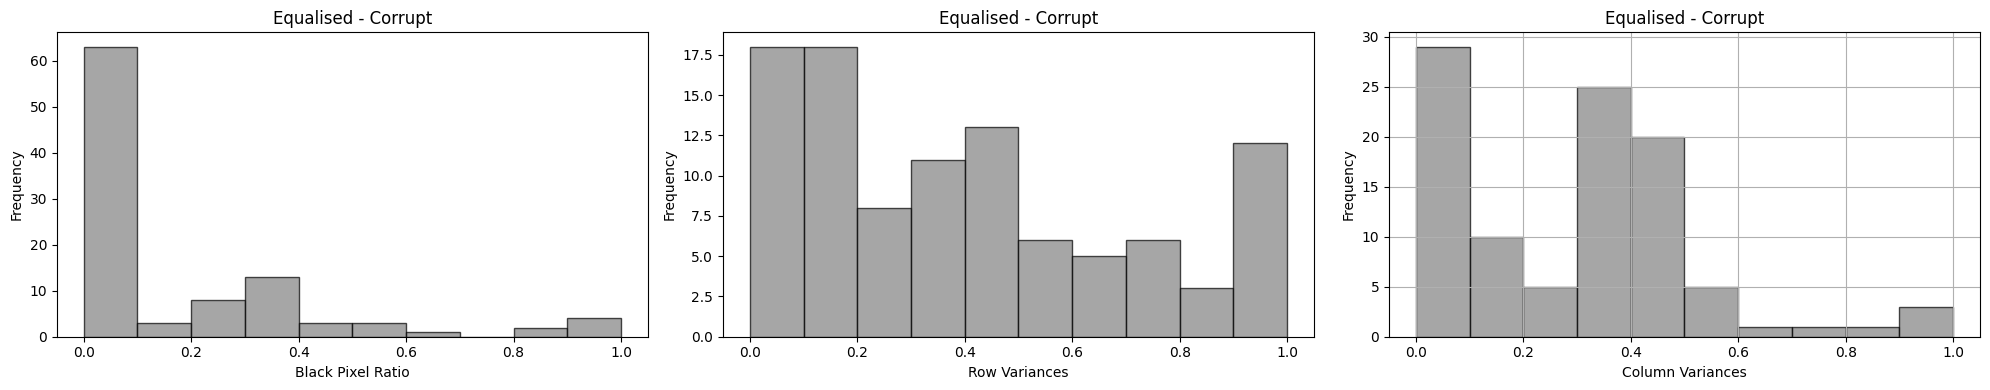

Missing_Data
Equalised

Black Pixel Ratio for Missing_Data
Mean:  0.0
Median:  0.0


Row Variance for Missing_Data
Mean:  0.347
Median:  0.349


Column Variance for Missing_Data
Mean:  0.2
Median:  0.11



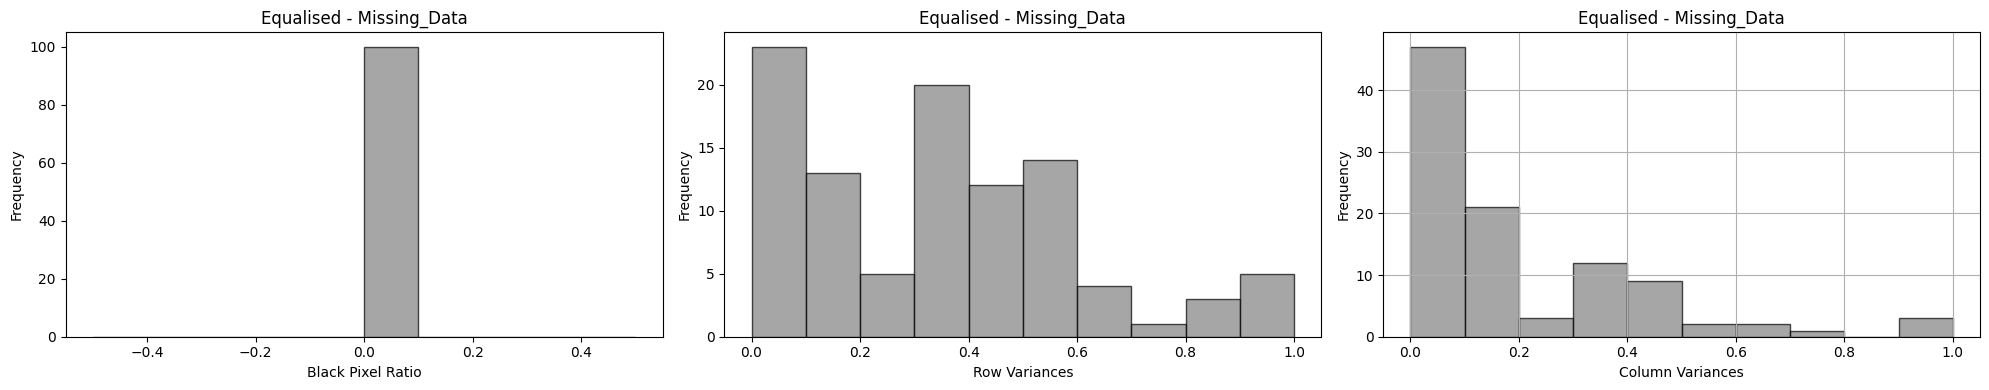

Noisy
Equalised

Black Pixel Ratio for Noisy
Mean:  0.119
Median:  0.007


Row Variance for Noisy
Mean:  0.129
Median:  0.08


Column Variance for Noisy
Mean:  0.148
Median:  0.068



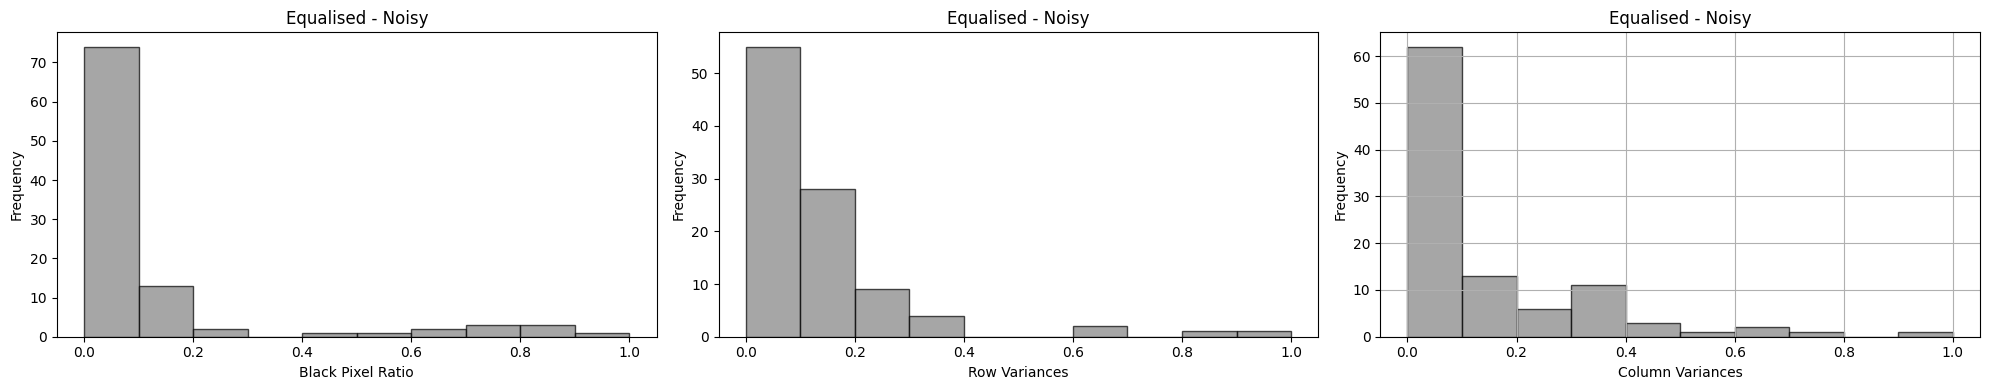

Priority
Equalised

Black Pixel Ratio for Priority
Mean:  0.0
Median:  0.0


Row Variance for Priority
Mean:  0.098
Median:  0.041


Column Variance for Priority
Mean:  0.118
Median:  0.059



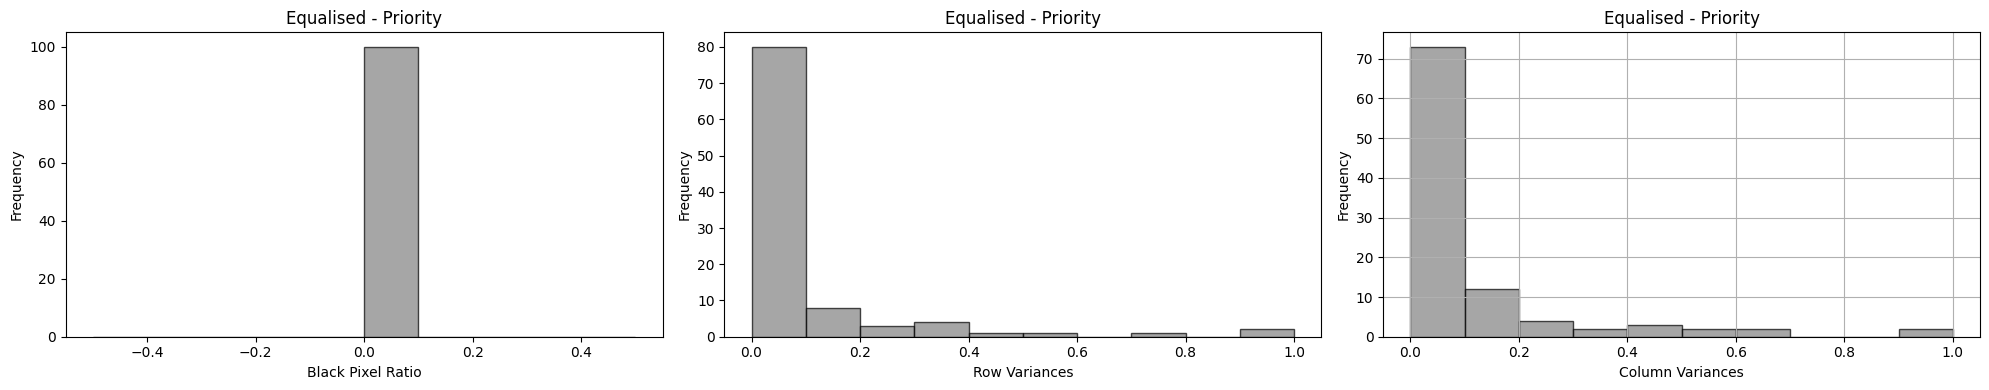

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Display images for each class
for label in unique_labels:
    # Find the indices of images belonging to the current class
    class_indices = np.where(train_labels == label)[0]
    
    # Select the first x images of this class
    num_images_to_display = min(100, len(class_indices))
    selected_indices = class_indices[:num_images_to_display]
    selected_images = train_images[selected_indices] / 255.0  # Normalize for better visualization

    black_pixel_ratios = []
    row_variances = []
    column_variances = []
    
    equalised_black_pixel_ratios = []
    equalised_row_variances = []
    equalised_column_variances = []
    
    for i, img in enumerate(selected_images):
        # Convert to grayscale using NumPy function
        grayscale_image = rgb_to_grayscale(img)

        equalised_image = histogram_equalization(grayscale_image)

        black_pixel_ratio_score = black_pixel_ratio(equalised_image)
        equalised_black_pixel_ratios.append(black_pixel_ratio_score)

        row_variance_score = row_variance(equalised_image)
        equalised_row_variances.append(row_variance_score)

        column_variance_score = column_variance(equalised_image)
        equalised_column_variances.append(column_variance_score)
    
    normalised_black_pixel_ratios =  normalize_values(np.array(equalised_black_pixel_ratios))
    normalised_row_variances =  normalize_values(np.array(equalised_row_variances))
    normalised_column_variances =  normalize_values(np.array(equalised_column_variances))

    # normalised_row_variances = normalised_row_variances[normalised_row_variances >= 0.1]
    # normalised_column_variances = normalised_column_variances[normalised_column_variances >= 0.1]

    
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))

    print(class_names[label])
    
    # sns.kdeplot(normalised_uniform_patches, ax=axes[1], fill=True, color='gray', bw_adjust=0.5)
    axes[0].hist(normalised_black_pixel_ratios, bins=10, alpha=0.7, color='gray', edgecolor='black')
    axes[0].set_title(f"Equalised - {class_names[label]}")
    axes[0].set_xlabel("Black Pixel Ratio")
    axes[0].set_ylabel("Frequency")

    # sns.kdeplot(normalised_uniform_patches, ax=axes[1], fill=True, color='gray', bw_adjust=0.5)
    axes[1].hist(normalised_row_variances, bins=10, alpha=0.7, color='gray', edgecolor='black')
    axes[1].set_title(f"Equalised - {class_names[label]}")
    axes[1].set_xlabel("Row Variances")
    axes[1].set_ylabel("Frequency")

    # sns.kdeplot(normalised_uniform_patches, ax=axes[1], fill=True, color='gray', bw_adjust=0.5)
    axes[2].hist(normalised_column_variances, bins=10, alpha=0.7, color='gray', edgecolor='black')
    axes[2].set_title(f"Equalised - {class_names[label]}")
    axes[2].set_xlabel("Column Variances")
    axes[2].set_ylabel("Frequency")

    
    print("Equalised")
    print()
    print(f"Black Pixel Ratio for {class_names[label]}")
    print("="*50)
    print(f"Mean: ", np.mean(normalised_black_pixel_ratios).round(3))
    print(f"Median: ", np.median(normalised_black_pixel_ratios).round(3))
    # print(f"Mode", stats.mode(normalized_equalised_variances))
    print()

    print()
    print(f"Row Variance for {class_names[label]}")
    print("="*50)
    print(f"Mean: ", np.mean(normalised_row_variances).round(3))
    print(f"Median: ", np.median(normalised_row_variances).round(3))
    # print(f"Mode", stats.mode(normalized_equalised_variances))
    print()

    print()
    print(f"Column Variance for {class_names[label]}")
    print("="*50)
    print(f"Mean: ", np.mean(normalised_column_variances).round(3))
    print(f"Median: ", np.median(normalised_column_variances).round(3))
    # print(f"Mode", stats.mode(normalized_equalised_variances))
    print()
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [30]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats


# # Display images for each class
# for label in unique_labels:
#     # Find the indices of images belonging to the current class
#     class_indices = np.where(train_labels == label)[0]
    
#     # Select the first x images of this class
#     num_images_to_display = min(100, len(class_indices))
#     selected_indices = class_indices[:num_images_to_display]
#     selected_images = train_images[selected_indices] / 255.0  # Normalize for better visualization

#     black_pixel_ratios = []
#     row_variances = []
#     column_variances = []
    
#     equalised_black_pixel_ratios = []
#     equalised_row_variances = []
#     equalised_column_variances = []
    
#     for i, img in enumerate(selected_images):
#         # Convert to grayscale using NumPy function
#         grayscale_image = rgb_to_grayscale(img)

#         equalised_image = histogram_equalization(grayscale_image)

#         black_pixel_ratio_score = black_pixel_ratio(equalised_image)
#         equalised_black_pixel_ratios.append(black_pixel_ratio_score)
    
#     normalised_black_pixel_ratios =  normalize_values(np.array(equalised_black_pixel_ratios))
#     fig, axes = plt.subplots(1, 2, figsize=(20, 4))

#     print(class_names[label])
    
#     # sns.kdeplot(normalised_uniform_patches, ax=axes[1], fill=True, color='gray', bw_adjust=0.5)
#     axes[0].hist(normalised_black_pixel_ratios, bins=10, alpha=0.7, color='gray', edgecolor='black')
#     axes[0].set_title(f"Equalised - {class_names[label]}")
#     axes[0].set_xlabel("Black Pixel Ratio")
#     axes[0].set_ylabel("Frequency")


    
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define class names
# class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# # Function to convert RGB image to grayscale using NumPy
# def rgb_to_grayscale(image):
#     """Convert an RGB image to grayscale using NumPy."""
#     return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Luminosity formula

# # Get unique labels
# unique_labels = np.unique(train_labels)

# # Function to apply Histogram Equalization using NumPy
# def histogram_equalization(image):
#     """Apply histogram equalization to a grayscale image."""
#     image_flattened = image.flatten()  # Flatten image into 1D

#     # Compute histogram
#     hist, bins = np.histogram(image_flattened, bins=256, range=(0, 1), density=True)

#     # Compute the Cumulative Distribution Function (CDF)
#     cdf = hist.cumsum()
#     cdf_normalized = cdf / cdf.max()  # Normalize to range [0,1]

#     # Use linear interpolation to find new pixel values
#     equalized_image = np.interp(image_flattened, bins[:-1], cdf_normalized)

#     return equalized_image.reshape(image.shape)  # Reshape back to original image size


# # Display histograms for each class
# for label in unique_labels:
#     # Find the indices of images belonging to the current class
#     class_indices = np.where(train_labels == label)[0]
    
#     # Select the first 5 images of this class
#     num_images_to_display = min(num_images_to_process, len(class_indices))
#     selected_indices = class_indices[:num_images_to_display]
#     selected_images = train_images[selected_indices] / 255.0  # Normalize for better visualization

#     # Convert images to grayscale
#     grayscale_images = np.array([rgb_to_grayscale(img) for img in selected_images])

#     # Apply Histogram Equalization
#     equalised_images = np.array([histogram_equalization(img) for img in grayscale_images])
    
#     # Flatten grayscale images into 1D for histogram
#     grayscale_pixel_values = grayscale_images.flatten()
#     equalised_pixel_values = equalised_images.flatten()
    

#     # Apply cutoff: Keep values between 0.1 and 1.0
#     # pixel_values = pixel_values[pixel_values >= 0.3]
    
#     # Plot histogram
#     fig, axes = plt.subplots(1, 2, figsize=(20, 4))
    
#     plt.hist(grayscale_pixel_values, bins=50, range=(0, 1), alpha=0.7, color='gray', edgecolor='black')
#     axes[0].hist(grayscale_pixel_values, bins=256, range=(0, 1), alpha=0.7, color='gray', edgecolor='black')
#     axes[0].set_title(f"Grayscale Intensity Distribution - {class_names[label]}")
#     axes[0].set_xlabel("Pixel Intensity (0-1)")
#     axes[0].set_ylabel("Frequency")

#     axes[1].hist(equalised_pixel_values, bins=50, range=(0, 1), alpha=0.7, color='gray', edgecolor='black')
#     axes[1].set_title(f"Equalised Intensity Distribution - {class_names[label]}")
#     axes[1].set_xlabel("Pixel Intensity (0-1)")
#     axes[1].set_ylabel("Frequency")
#     plt.grid(True)

#     # Show the histogram
#     plt.show()


The images in the dataset appear to have distinct visual characteristics that make them easy to classify by eye. For example, `Blurry`, `Corrupt`, and `Missing Data` images each have unique visual patterns and anomalies that differentiate them from one another. Given these clear differences, we can reasonably expect that machine learning models would also be able to classify these images with high accuracy, as the features that distinguish each class are visually pronounced and easily identifiable.

If we were to rank these images in terms of importance based on their significance in capturing and transmitting them back to Earth, the order would be:

1.	`Priority`: Images with the highest importance and usability.
2.	`Noisy` & `Blurry`: Impure images that are potentially recoverable with preprocessing.
3.	`Corrupt` and `Missing Data`: Images with severe issues or missing information, making recovery or reuse least likely.

This ranking will help assess model performance by testing its ability to handle different levels of data quality and recover meaningful information from problematic images.

---

### Class Balance Check

In [20]:
# Check the balance of the classes in each dataset
train_class_counts = np.bincount(train_labels)
val_class_counts = np.bincount(val_labels)
test_class_counts = np.bincount(test_labels)

# Display the class distribution with class names
print("\nClass distribution:")
print(f"Training set: {dict(zip(class_names, train_class_counts))}")
print(f"Validation set: {dict(zip(class_names, val_class_counts))}")
print(f"Testing set: {dict(zip(class_names, test_class_counts))}")


Class distribution:
Training set: {'Blurry': 2149, 'Corrupt': 635, 'Missing_Data': 1186, 'Noisy': 2140, 'Priority': 3601}
Validation set: {'Blurry': 727, 'Corrupt': 222, 'Missing_Data': 421, 'Noisy': 721, 'Priority': 1146}
Testing set: {'Blurry': 668, 'Corrupt': 213, 'Missing_Data': 414, 'Noisy': 721, 'Priority': 1221}


The `Priority` class has the most data, followed by `Noisy` and `Blurry`, while `Corrupt` has the least, indicating class imbalance.

---

# Creating ML Model Dataset

In [ ]:
###### import pandas as pd

selected_train_images = []
selected_val_images = []
selected_test_images = []

equalised_train_images = []
equalised_val_images = []
equalised_test_images = []

train_data_rows = []
val_data_rows = []
test_data_rows = []

for label in unique_labels:
    # Find the indices of images belonging to the current class
    train_class_indices = np.where(train_labels == label)[0]
    val_class_indices = np.where(val_labels == label)[0]
    test_class_indices = np.where(test_labels == label)[0]
    
    # Select the first 5 images of this class
    train_num_images_to_display = min(50, len(train_class_indices))
    val_num_images_to_display = min(50, len(val_class_indices))
    test_num_images_to_display = min(50, len(test_class_indices))
    
    selected_train_indices = train_class_indices[:train_num_images_to_display]
    selected_val_indices = train_class_indices[:val_num_images_to_display]
    selected_test_indices = train_class_indices[:test_num_images_to_display]
    
    selected_train_images = train_images[selected_train_indices] / 255.0  # Normalize images for better visualization
    selected_val_images = train_images[selected_val_indices] / 255.0  # Normalize images for better visualization
    selected_test_images = train_images[selected_test_indices] / 255.0  # Normalize images for better visualization

    
    for image in selected_train_images:
        grayscale_image = rgb_to_grayscale(image)
        equalised = histogram_equalization(grayscale_image)  # Apply histogram equalization
        
        equalised_train_images.append(equalised)
        
        # Compute Laplacian variance
        variance = laplacian_variance(equalised)

        row_variance_score = row_variance(equalised)

        # Append to DataFrame
        train_data_rows.append({'Laplacian_Variance': variance, 'Row_Variance': row_variance_score, 'Label': label})


    print(f"{class_names[label]} Train Images Equalised")

    for image in selected_val_images:
        grayscale_image = rgb_to_grayscale(image)
        equalised = histogram_equalization(grayscale_image)  # Apply histogram equalization
        
        equalised_train_images.append(equalised)
        
        # Compute Laplacian variance
        variance = laplacian_variance(equalised)

        row_variance_score = row_variance(equalised)
        
        # Append to DataFrame
        val_data_rows.append({'Laplacian_Variance': variance, 'Row_Variance': row_variance_score, 'Label': label})


    print(f"{class_names[label]} Val Images Equalised")

    for image in selected_test_images:
        grayscale_image = rgb_to_grayscale(image)
        equalised = histogram_equalization(grayscale_image)  # Apply histogram equalization
        
        equalised_train_images.append(equalised)
        
        # Compute Laplacian variance
        variance = laplacian_variance(equalised)

        row_variance_score = row_variance(equalised)

        # Append to DataFrame
        test_data_rows.append({'Laplacian_Variance': variance, 'Row_Variance': row_variance_score, 'Label': label})


    print(f"{class_names[label]} Test Images Equalised")


train_data_df = pd.DataFrame(train_data_rows)
val_data_df = pd.DataFrame(val_data_rows)
test_data_df = pd.DataFrame(test_data_rows)

def class3_mapping(label):
    if label in [0, 3]:
        return 0
    elif label in [1, 2]:
        return 1
    else:
        return 2
        
# Shuffle the DataFrame
train_data_df = train_data_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_data_df['Priority'] = train_data_df['Label'].map(lambda x: 1 if x == 4 else 0)

trand_data_df_2 = train_data_df.copy()
trand_data_df_2 = trand_data_df_2[trand_data_df_2["Priority"] != 1]
trand_data_df_2['class3'] = train_data_df['Label'].apply(class3_mapping)
trand_data_df_2 = trand_data_df_2.drop(columns=["Priority"])

val_data_df = val_data_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_data_df['Priority'] = val_data_df['Label'].map(lambda x: 1 if x == 4 else 0)
val_data_df['class3'] = val_data_df['Label'].apply(class3_mapping)

test_data_df = test_data_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_data_df['Priority'] = test_data_df['Label'].map(lambda x: 1 if x == 4 else 0)
test_data_df['class3'] = test_data_df['Label'].apply(class3_mapping)

# display(train_balanced_df.head())
# display(train_balanced_df["Priority"].value_counts())

In [38]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot histogram of Laplacian Variance with Priority as hue
# plt.figure(figsize=(10, 6))
# sns.histplot(data=train_data_df, x="Laplacian_Variance", hue="Priority", kde=True, bins=30, alpha=0.6)

# # Labels and title
# plt.xlabel("Laplacian Variance")
# plt.ylabel("Frequency")
# plt.title("Histogram of Laplacian Variance with Priority as Hue")

# plt.show()

# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create scatter plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=train_data_df, 
#     x='Laplacian_Variance', 
#     y='Row_Variance', 
#     hue='class3', 
#     palette='viridis',  # Adjust color mapping
#     alpha=0.7  # Transparency for better visibility
# )

# # Labels and title
# plt.xlabel("Laplacian Variance (Sharpness)")
# plt.ylabel("Row Variance (Texture)")
# plt.title("Scatter Plot of Laplacian Variance vs. Row Variance")

# # Show legend and grid
# plt.legend(title="Class 3 Category")
# plt.grid(True)

# # Display plot
# plt.show()

# Handling class imbalance

In [42]:
from sklearn.utils import resample

# Downsampling
train_majority_class = train_data_df[train_data_df['Priority'] == 0]
train_minority_class = train_data_df[train_data_df['Priority'] == 1]

train_majority_downsampled = resample(train_majority_class, 
                                replace=False,  # Sample without replacement
                                n_samples=len(train_minority_class),  # Match minority class size
                                random_state=42)

train_balanced_df = pd.concat([train_majority_downsampled, train_minority_class])
train_balanced_df = train_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)



val_majority_class = val_data_df[test_data_df['Priority'] == 0]
val_minority_class = val_data_df[test_data_df['Priority'] == 1]

val_majority_downsampled = resample(val_majority_class, 
                                replace=False,  # Sample without replacement
                                n_samples=len(val_minority_class),  # Match minority class size
                                random_state=42)

val_balanced_df = pd.concat([val_majority_downsampled, val_minority_class])
val_balanced_df = val_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)





test_majority_class = test_data_df[test_data_df['Priority'] == 0]
test_minority_class = test_data_df[test_data_df['Priority'] == 1]

test_majority_downsampled = resample(test_majority_class, 
                                replace=False,  # Sample without replacement
                                n_samples=len(test_minority_class),  # Match minority class size
                                random_state=42)

test_balanced_df = pd.concat([test_majority_downsampled, test_minority_class])
test_balanced_df = test_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

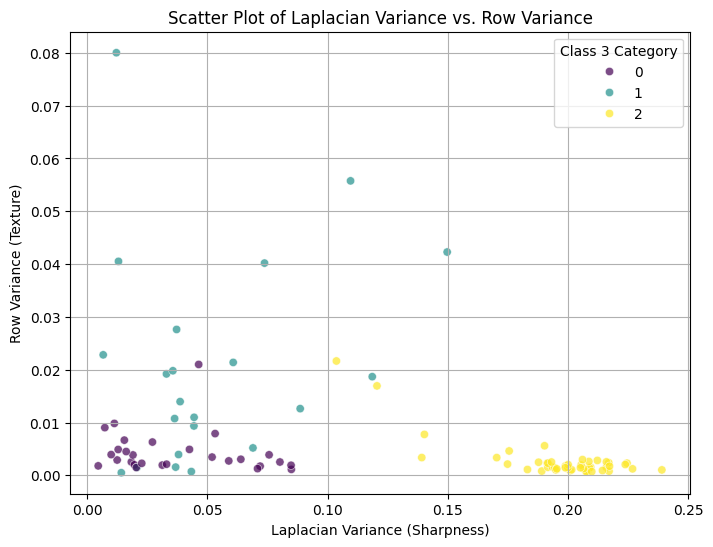

In [43]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create scatter plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=train_balanced_df, 
#     x='Laplacian_Variance', 
#     y='Row_Variance', 
#     hue='class3', 
#     palette='viridis',  # Adjust color mapping
#     alpha=0.7  # Transparency for better visibility
# )

# # Labels and title
# plt.xlabel("Laplacian Variance (Sharpness)")
# plt.ylabel("Row Variance (Texture)")
# plt.title("Scatter Plot of Laplacian Variance vs. Row Variance")

# # Show legend and grid
# plt.legend(title="Class 3 Category")
# plt.grid(True)

# # Display plot
# plt.show()

# Building ML Model

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# Selecting features and target
features = ["Laplacian_Variance", "Row_Variance"]  # Feature column
target = "class3"  # Target column

# Splitting into X (features) and y (target)
X_train = train_balanced_df[features]
y_train = train_balanced_df[target]

X_val = val_balanced_df[features]
y_val = val_balanced_df[target]

X_test = test_balanced_df[features]
y_test = test_balanced_df[target]

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# # Initialize and train the Decision Tree model
# model = DecisionTreeClassifier(criterion="gini", max_depth=2, random_state=42)  # Using Gini impurity, limited depth
# model.fit(X_train_scaled, y_train)

# Save the model
joblib.dump(model, "decision_tree_model.pkl")

# # Save the model
# joblib.dump(model, "logistic_regression_model.pkl")

# Save the scaler (since we need to normalize new inputs in the future)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

# Evaluate ML Model

In [62]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# cnf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n=== Test Set Classification Report ===")
print(test_report)

# Display accuracy scores
print("\n=== Accuracy Scores ===")
print(f"Test Accuracy: {test_accuracy:.4f}")

# class_names=[0,1] # name  of classes
# fig, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)
# # create heatmap
# sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')


=== Test Set Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        28
           1       0.88      0.68      0.77        22
           2       1.00      0.98      0.99        50

    accuracy                           0.91       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.92      0.91      0.91       100


=== Accuracy Scores ===
Test Accuracy: 0.9100


In [64]:
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree

# # Plot the decision tree
# plt.figure(figsize=(12, 6))  # Adjust figure size
# plot_tree(model, feature_names=features, class_names=["CMD", "NB", "P"], filled=True, rounded=True)

# # Show the tree plot
# plt.title("Decision Tree Visualization")
# plt.show()

# Create Ensemble Model

In [26]:
import pickle

def ensemble_model(image):
    # Load the model
    with open("logistic_regression_model.pkl", "wb") as f:
        pickle.dump(model, f)
    
    # Load the scaler
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
        
    # Convert to grayscale and apply histogram equalization
    grayscale_image = rgb_to_grayscale(image)
    equalised = histogram_equalization(grayscale_image)

    # Compute Laplacian variance
    variance = laplacian_variance(equalised)

    # Scale the variance using the same scaler used during training
    variance_scaled = scaler.transform([[variance]])  # Ensure it's in a 2D array format

    # Predict priority
    priority = model.predict(variance_scaled)[0]  # Get the predicted class (0 or 1)

    # If priority is 1, return, else continue
    if priority == 1:
        return 4
    else:
        return "Not a priority class, continue processing..."

# Use Ensemble Model

All imports in top
Clarify weird libraries
Use docstrings to explain functions
Use comments heavily
Use markdown structure heavily
Reduce ChatGPT

### Finally, removing data from memory

**⚠️ Important Notice**: In this shared environment (ilifu), efficient memory usage is crucial. Freeing unused data helps prevent memory bottlenecks, ensuring smooth performance for both your work and other users, especially when working with large datasets.

**Make sure to follow this same practice when you develop your own pipeline during the hackathon to optimize performance and resource allocation.**

In [27]:
import gc

# Remove the data from memory
del train_images, train_labels, val_images, val_labels, test_images, test_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data removed from memory.")

Data removed from memory.


---